In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.neighbors import KernelDensity
from sklearn.metrics.pairwise import rbf_kernel

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from statsmodels.nonparametric.kernel_regression import KernelReg

In [2]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

# Task 0

Look at examples of kernel functions and apply therm to estimate density using Iris dataset.

## Case of 2 Gaussians

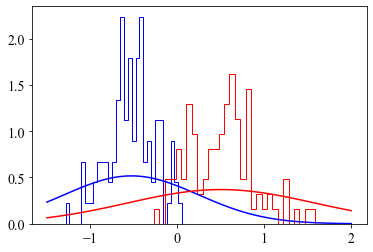

In [3]:
np.random.seed(42)
x1 = np.random.normal(-0.5, 0.3, size=(100, 1))
x2 = np.random.normal(0.5, 0.4, size=(100, 1))

plt.figure()
plt.hist(x1, bins=30, histtype='step', density=True, color='b')
plt.hist(x2, bins=30, histtype='step', density=True, color='r')


bandwidth = 1.06 * x1.std() * x1.shape[0]**0.2
kde1 = KernelDensity(bandwidth=bandwidth).fit(x1)

bandwidth = 1.06 * x2.std() * x2.shape[0]**0.2
kde2 = KernelDensity(bandwidth=bandwidth).fit(x2)

x = np.linspace(-1.5, 2, 100).reshape(-1, 1)
p1 = np.exp(kde1.score_samples(x))
p2 = np.exp(kde2.score_samples(x))
plt.plot(x, p1, color='b')
plt.plot(x, p2, color='r')
plt.show()

## Iris dataset

In [4]:
data, classes = load_iris(return_X_y=True)

In [5]:
# estimate density for each class
kde = []
for label in [0, 1, 2]:
    kde.append(KernelDensity(kernel='gaussian'))
    kde[-1].fit(data[classes == label])
    print("Bandwidth: ", kde[-1].bandwidth)

densities = [k.score_samples(data).reshape(-1, 1) for k in kde]

densities = np.hstack(densities)
predicted_labels = np.argmax(densities, axis=1)

# calculate accuracy
accuracy = np.sum(predicted_labels == classes)
print("Accuracy: ", accuracy / len(classes))

Bandwidth:  1.0
Bandwidth:  1.0
Bandwidth:  1.0
Accuracy:  0.9466666666666667


### Tune bandwidth

We will perform a simple grid search over the the range of values for the bandwidth using a convinient function `GridSearchCV` from the `scikit-learn` library.

In [6]:
params = {'bandwidth': np.logspace(-1, 1, 20)}

kde = []
for label in [0, 1, 2]:
    grid_search = GridSearchCV(KernelDensity(), params)
    grid_search.fit(data[classes == label])
    kde.append(grid_search.best_estimator_)
    print('Bandwidth = ', kde[-1].bandwidth)
    
densities = [k.score_samples(data).reshape(-1, 1) for k in kde]

densities = np.hstack(densities)
predicted_labels = np.argmax(densities, axis=1)

# calculate accuracy
accuracy = np.sum(predicted_labels == classes)
print("Accuracy: ", accuracy / len(classes))

Bandwidth =  0.16237767391887217
Bandwidth =  0.16237767391887217
Bandwidth =  0.20691380811147897
Accuracy:  1.0


# Task 1

Get the data on fragments of glass collected in forensic work from the book website. Estimate the density of the first variable (refractive index) using a histogram and use a kernel density estimator. Use cross-validation to choose the amount of smoothing. Experiment with different binwidths and bandwidths. Construct 95 percent confidence bands for your estimators.

In [7]:
df = pd.read_csv("glass.csv", sep=",")[["RI", "Al"]]
sample = df["RI"].values

sample_min, sample_max = np.min(sample), np.max(sample)
delta = sample_max - sample_min
grid = np.linspace(sample_min, sample_max, 100)

## Histogram

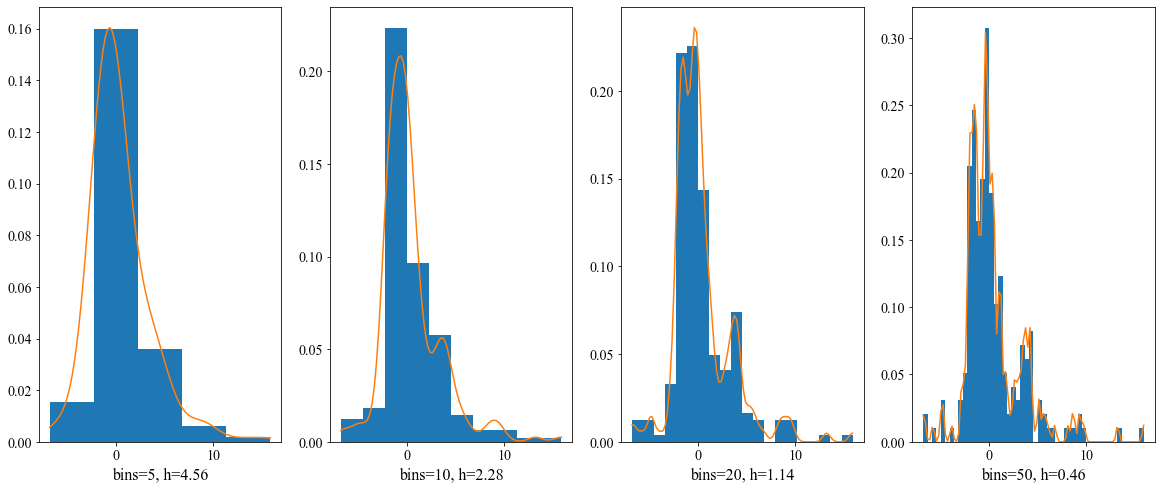

In [8]:
bin_list = [5, 10, 20, 50]
fig, axes = plt.subplots(1, len(bin_list), figsize=(20, 8))
for ax, bins in zip(axes, bin_list):
    
    ax.hist(sample, bins=bins, density=True)
    
    h = delta / bins / 3
    density = KernelDensity(kernel="gaussian", bandwidth=h).fit(sample[:, None])
    ax.plot(grid, np.exp(density.score_samples(grid[:, None])))
    ax.set_xlabel(f"bins={bins}, h={delta / bins:.2f}")


    

### Estimate of risk using leave-one-out cross validation

$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\xs}[1]{\boldX^{(#1)}}$
$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\hatp}{\widehat{p}}$
$\newcommand{\hatJ}{\widehat{J}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

In leave-one-out cross validation, we remove a single point to see how estimate changes without it and do so for each point in our sample.


$$ J(h) = \int \hatp^2\lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx, $$

$$\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp. \label{eq1}\tag{1}$$


In [9]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    h_eff = (sample_max - sample_min) / bins
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    for i in range(n):
        mask[i] = False
        p = np.histogram(sample[mask], bins=bins, range=(sample_min, sample_max), density=True)[0]
        mask[i] = True
        index = np.int((sample[i] - sample_min) / h_eff)
        if index > 0 and index < len(p):   
            summ += p[index]
    summ = 2 * summ / n
    
    p = np.histogram(sample, bins=bins, range=(sample_min, sample_max), density=True)[0]
    summ2 = np.sum(p**2) * h
    return summ2 - summ

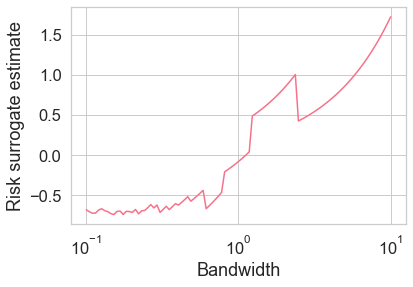

In [43]:
h_list = np.logspace(-1, 1, 100)
cv_hist = [cross_validation_histogram(sample, hi) for hi in h_list]
plt.figure()
plt.plot(h_list, cv_hist)
plt.xscale("log")
plt.xlabel("Bandwidth")
plt.ylabel("Risk surrogate estimate")
plt.show()

In [11]:
h_list[np.argmin(cv_hist)]

0.6711611767496284

## Kernel Density

In [44]:
kernel = lambda x, y, h: rbf_kernel(x, y, 0.5 / h**2) / (2 * np.pi)**(x.shape[1] / 2)

def density_se(grid, sample, h, alpha=0.05):
    n = len(sample)
    delta = np.max(sample) - np.min(sample)
    kernel_values = kernel(grid[:, None], sample[:, None], h) / h
    kernel_mean = np.mean(kernel_values, axis=1, keepdims=True)
    s2 = np.sum((kernel_values - kernel_mean)**2, axis=1) / (n-1)
    se = np.sqrt(s2 / n)
    m = delta / (3 * h)
    q = sps.norm.ppf((1+(1-alpha)**(1/m))/2)
    return q * se

ValueError: Found array with dim 3. Estimator expected <= 2.

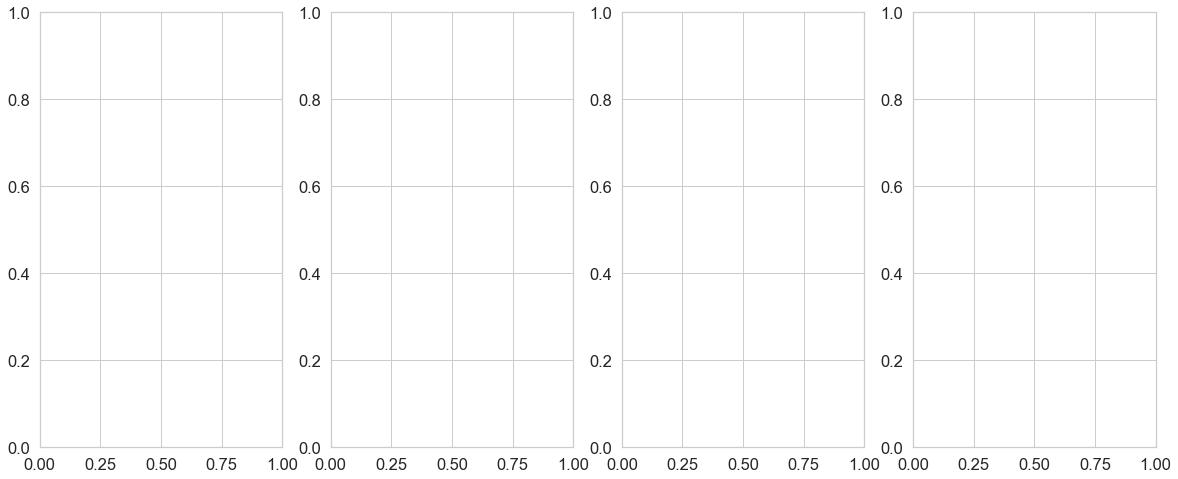

In [45]:
n = len(sample)
alpha = 0.05

h_list = [0.1, 0.3, 0.5, 1.0][::-1]
fig, axes = plt.subplots(1, len(h_list), figsize=(20, 8))
for ax, h in zip(axes, h_list):
    density = KernelDensity(kernel="gaussian", bandwidth=h).fit(sample[:, None])
    density_values = np.exp(density.score_samples(grid[:, None]))
    ax.plot(grid, density_values)
    ax.set_xlabel(f"h={h:.2f}")

    qse = density_se(grid, sample, h)
    ax.fill_between(grid, density_values-qse, density_values+qse, color='gray', alpha=0.2)    

In [14]:
def cross_validation_kernel(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    sample = sample[:, None]
    for i in range(n):
        mask[i] = False
        p = KernelDensity(bandwidth=h).fit(sample[mask])
        mask[i] = True
        summ += np.exp(p.score_samples(sample[i].reshape(1, 1)))
    summ = 2 * summ / n
    
    p = KernelDensity(bandwidth=h).fit(sample[mask]).score_samples(np.linspace(sample_min, sample_max, 101)[:, None])
    p /= p.sum()
    
    summ2 = np.sum(p**2) / h
    return (summ2 - summ).item()

In [41]:
h_list = np.logspace(-1, 1, 100)
cv_hist = [cross_validation_kernel(sample, hi) for hi in h_list]
plt.figure()
plt.plot(h_list, cv_hist)
plt.xscale("log")
plt.ylabel("CV risk estimate")
plt.xlabel("Bandwidth")
plt.show()

ValueError: Found array with dim 3. Estimator expected <= 2.

In [16]:
h_list[np.argmin(cv_hist)]

0.5184593543892911

### Different kernels

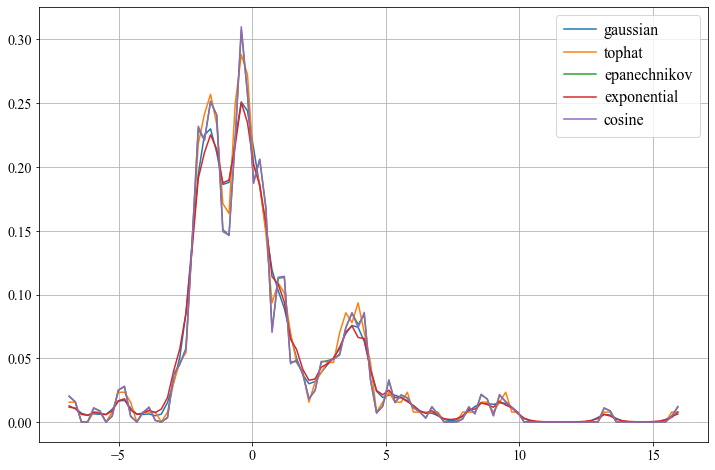

In [17]:
plt.figure(figsize=(12, 8))

for kernel_name in ["gaussian", "tophat", "epanechnikov", "exponential", "cosine"]:
    kde = KernelDensity(kernel=kernel_name, bandwidth=0.3).fit(sample[:, None])
    density_values = np.exp(kde.score_samples(grid[:, None]))
    plt.plot(grid, density_values, label=kernel_name)
    
plt.grid(True)
plt.legend()
plt.show()

# Task 2

Consider the data from task 1. Let $Y$ be refractive index and let $x$ be aluminum content (the fourth variable). Perform a nonparametric regression to fit the model $Y = f(x) + \varepsilon$. Use cross-validation to estimate the bandwidth. Construct 95 percent confidence bands for your estimate.

In [18]:
df = pd.read_csv("glass.csv", sep=",")[["RI", "Al"]]
target, sample = df["RI"].values, df["Al"].values

order = np.argsort(sample)[2:-3]
sample = sample[order, None]
target = target[order, None]

sample_min, sample_max = np.min(sample), np.max(sample)
delta = sample_max - sample_min
grid = np.linspace(sample_min, sample_max, 10000)[:, None]

In [19]:
def prediction_se(grid, sample, target, h, alpha=0.05):

    n = target.shape[0]
    sigma_hat2 = np.sum((target[1:] - target[:-1])**2) / (2 * (n-1))
    delta = np.max(sample) - np.min(sample)

    kernel_values = kernel(grid, sample, h)
    kernel_sum = np.sum(kernel_values, axis=1, keepdims=True)
#     print(kernel_values)

    nonzero_indices = kernel_sum[:, 0] > 1e-8
    kernel_weights = kernel_values
    kernel_weights[nonzero_indices] = kernel_weights[nonzero_indices] / kernel_sum[nonzero_indices]
    kernel_weights[~nonzero_indices] = 0

    se = np.sqrt(np.sum(kernel_weights**2, axis=1) * sigma_hat2)
    m = delta / (3 * h)
    q = sps.norm.ppf((1+(1-alpha)**(1/m))/2)
    return q*se

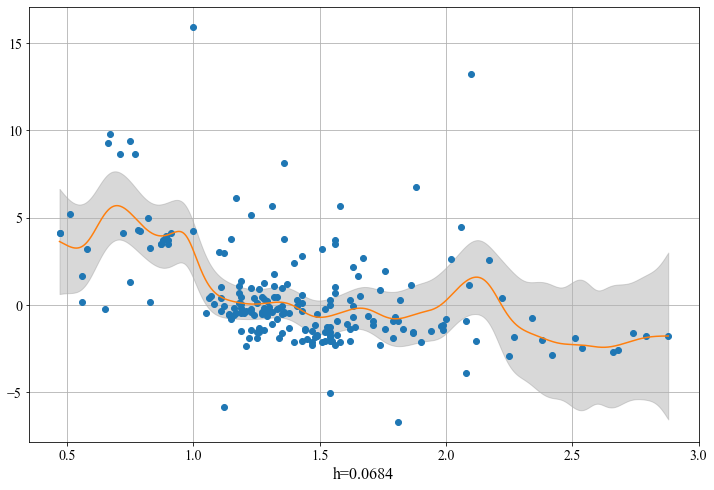

In [20]:
# h = np.r_[1e-2]
# nw = KernelReg(target, sample, var_type="c", reg_type="lc", bw=h)
nw = KernelReg(target, sample, var_type="c", reg_type="lc")

target_pred, margins = nw.fit(grid)

qse = prediction_se(grid, sample, target, nw.bw.item())

plt.figure(figsize=(12, 8))
plt.plot(sample[:, 0], target[:, 0], "o")
plt.plot(grid[:, 0], target_pred)
plt.xlabel(f"h={nw.bw.item():.4f}")
plt.fill_between(grid[:, 0], target_pred-qse, target_pred+qse, color='gray', alpha=0.3)
plt.grid(True)

In [21]:
def cross_validation_regression(sample, target, h):
    n = sample.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    bw = np.r_[h]
    summ = 0
    for i in range(n):
        mask[i] = False
        nw = KernelReg(target[mask], sample[mask], var_type="c", reg_type="lc", bw=bw)
        mask[i] = True
        summ += (target[i] - nw.fit(sample[i].reshape(1, 1))[0])**2
    return summ.item()

In [22]:
h_list = np.logspace(-3, 0, 100)
cv_hist = np.array([cross_validation_regression(sample, target, hi) for hi in h_list])

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:238: RuntimeWarning: invalid value encountered in true_divide
  G = G_numer / G_denom
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:250: RuntimeWarning: invalid value encountered in true_divide
  B_x = d_mx / f_x - G * d_fx / f_x
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:251: RuntimeWarning: invalid value encountered in true_divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)


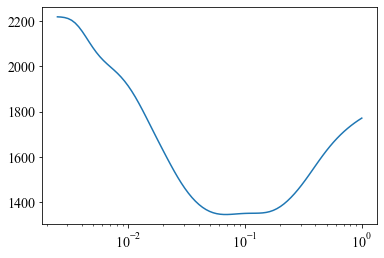

In [23]:
plt.plot(h_list, cv_hist)
plt.xscale("log")

In [24]:
no_na_index = ~np.isnan(cv_hist)
h_list = h_list[no_na_index]
cv_hist = cv_hist[no_na_index]
h_list[np.argmin(cv_hist)]

0.07054802310718646

# Task 3

In [25]:
import seaborn
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'legend.frameon': True})
sns.set_palette('husl', n_colors=8)

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### Let us create small training set

In [26]:
X_train = np.array([[.5], [1]])
y_train = np.array([[.5], [1]])
X_test = np.array([[0], [2]])

np.random.seed(0)

## Ridge Regression

In ridge regression:
$$\|\mathbf{y} - \mathbf{X}\beta\|^2_2 + \lambda\|\beta\|^2_2$$

$$
\beta = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}
$$

Let us show that $$(\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T = \mathbf{X}^T(\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I})^{-1}$$

Multiplying from the left by $(\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})$ and from the right by $(\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I})$
we obtain identity

$$
\mathbf{X}^T(\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I}) = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})\mathbf{X}^T
$$

So, for prediction at new point $x_*$ we can write

$$
y_* = x_* \mathbf{X}^T(\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I})^{-1}\mathbf{y}
$$

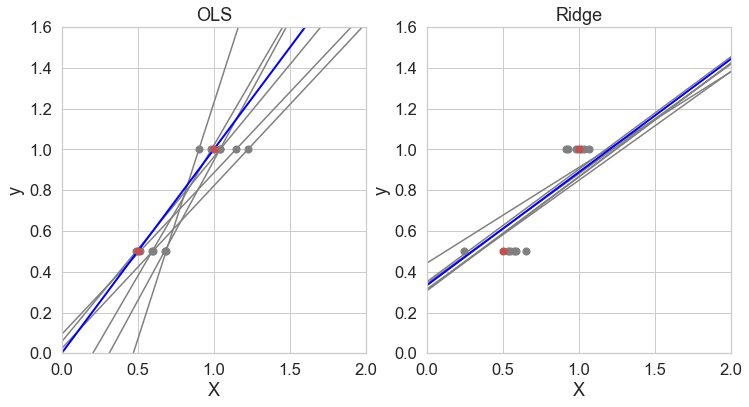

In [27]:

classifiers = dict(OLS=linear_model.LinearRegression(),
                   Ridge=linear_model.Ridge(alpha=.1))

fignum = 1
figure = plt.figure(figsize=(12, 6))
for name, model in classifiers.items():

    ax = figure.add_subplot(1, 2, fignum)
    ax.set_title(name)

    for _ in range(6):
        this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train
        model.fit(this_X, y_train)

        ax.plot(X_test, model.predict(X_test), color='.5')
        ax.scatter(this_X, y_train, s=50, c='.5', marker='o', zorder=1)

    model.fit(X_train, y_train)
    ax.plot(X_test, model.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, marker='o', c='r', s=50, zorder=10)

    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_xlim(0, 2)
    fignum += 1

plt.show()

## Kernel Ridge Regression

So, for prediction at new point $x_*$ in Ridge regression:

$$
y_* = x_* \mathbf{X}^T(\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I})^{-1}\mathbf{y}
$$

$$
y_* = \mathbf{k}_* (\mathbf{K} + \lambda \mathbf{I})^{-1}\mathbf{y}
$$

where $\mathbf{k}_* = k(x_*, x_1), \ldots, k(x_*, x_N), \mathbf{K} = \|k(x_i, x_j)\|_{i,j=1}^N$,
$k(x, y)$ is a **kernel function**

#### Kernel function can be seen as an inner product
$$
k(x, y) = <\phi(x), \phi(y)>
$$
**Example**
* $\phi(x) = (x_1^2, x_2^2, \sqrt{2}x_1x_2)$
* $k(x, y) = (x, y)^2$

### Examples of kernel functions:

* **Polynomial**: $k(x, y) = <x, y>^d$
* **Radial basis function (RBF)**: $k(x, y) = \exp \left ( - \gamma \|x - y\|^2 \right )$
* **Sigmoid**: $k(x, y) = {\rm tanh}(<x, y>\eta + v)$

### Approximation to artificial data generated by branin function:

$$f(x_1, x_2) = (x_2 - a  x_1^2 +  b x_1 - c)^2 +  d \cos(x_1) + e;$$
$$x_1 \in [-5, 10], x_2 \in [0, 15];$$
$$a = 5.1 / 4 / \pi^2;$$
$$b = 5 / \pi;$$
$$c = 6;$$
$$d = 10 (1 - 1 / 8 / \pi);$$
$$e = 10.$$

In [28]:
def branin_function(x1, x2, a, b, c, d, e):
    return (x2 - a * x1**2 + b * x1 - c)**2 + d * np.cos(x1) + e

In [29]:
def plot_branin_function(x1, x2, y, minmax_values=[[-5, 10], [0, 15]],\
    view_angles=[25, -55], title='Branin function', zlim=[0, 250]):

    fig = plt.figure(figsize=(20, 12))
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.7, edgecolor="k")
    ax.set_xlim3d(*minmax_values[0])
    ax.set_ylim3d(*minmax_values[1])
    ax.set_zlim3d(*zlim)
    ax.set_title(title)
    ax.view_init(*view_angles)
    return ax

In [30]:
step = 0.1
x1, x2 = np.mgrid[-5:10:step, 0:15:step]
a = 5.1 / (4 * np.pi**2)
b = 5 / np.pi
c = 6
d = 10 * (1 - 1 / (8 * np.pi))
e = 10

In [31]:
y = branin_function(x1, x2, a, b, c, d, e)

In [32]:
m, n = y.shape
l = m*n
train_index = np.random.randint(low=0, high=l, size=np.int(0.002*l))

In [33]:
train_y = y.ravel()[train_index]
train_y.shape

(45,)

In [34]:
train_x = np.hstack((x1[train_index // n, :1], x2[:1, train_index % n].T))

In [35]:
print('Train X shape:', train_x.shape)
print('Train Y shape:', train_y.shape)

Train X shape: (45, 2)
Train Y shape: (45,)


In [36]:
model = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

model.fit(train_x, train_y)

train_prediction = model.predict(train_x)

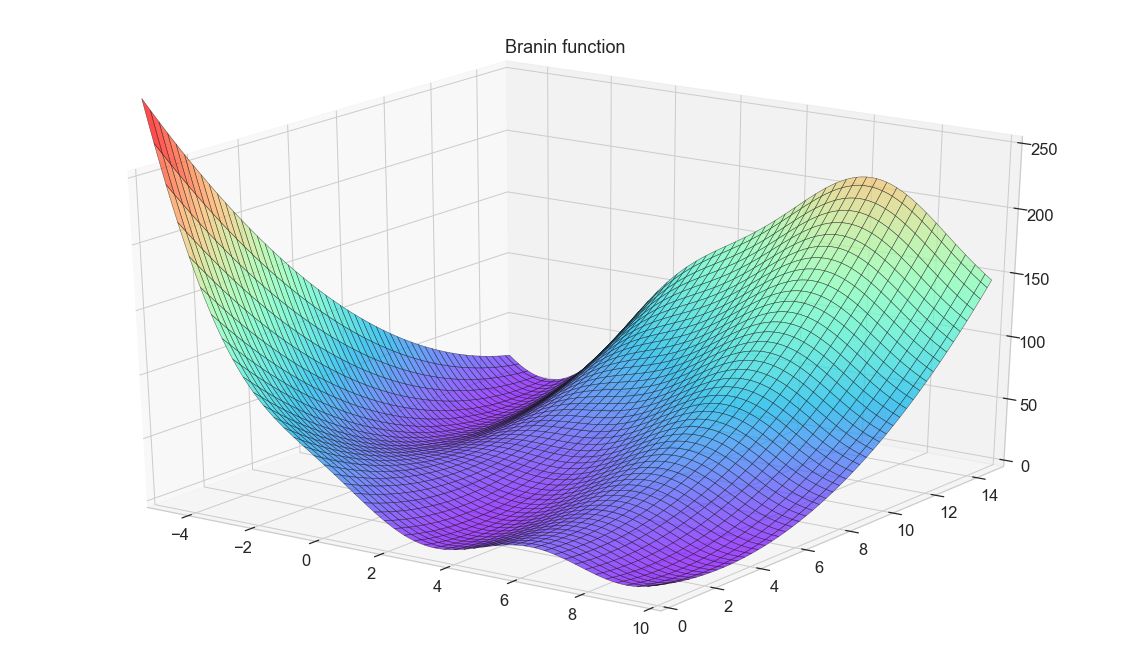

In [37]:
plot_branin_function(x1, x2, y)

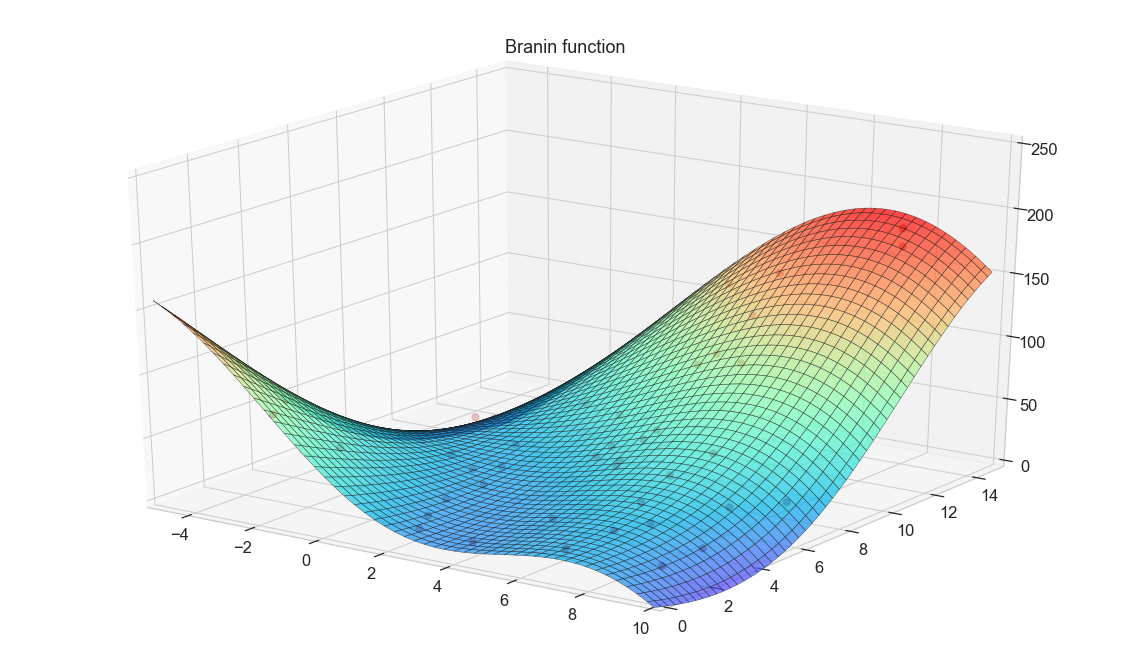

In [38]:
y_pred = model.predict(np.hstack((x1.reshape(-1, 1), x2.reshape(-1, 1)))).reshape(x1.shape)
ax = plot_branin_function(x1, x2, y_pred)
ax.scatter(train_x[:, 0], train_x[:, 1], train_y, marker="o", s=50, c="r")

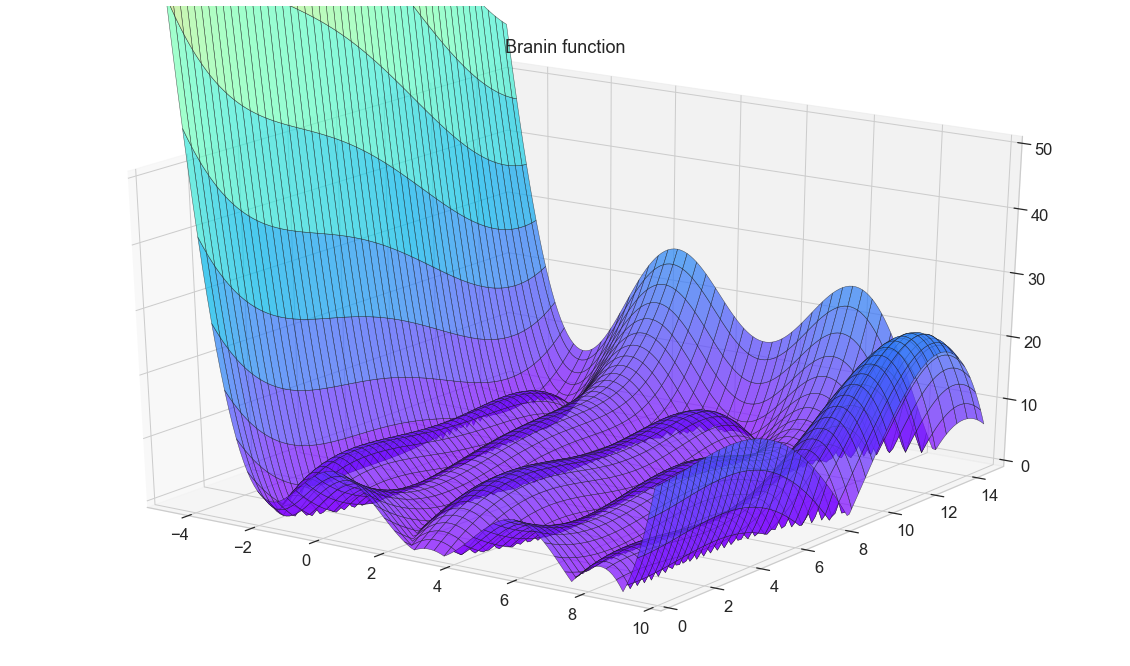

In [39]:
plot_branin_function(x1, x2, np.abs(y-model.predict(np.hstack((x1.reshape(-1, 1), x2.reshape(-1, 1)))).reshape(x1.shape)), zlim=(0, 50))